# Imports

In [80]:
import os
import warnings 

#
import numpy               as np
import pandas              as pd
import seaborn             as sns

from tabulate                import tabulate
from catboost                import CatBoostRegressor
from IPython.core.display    import HTML
from sklearn.model_selection import train_test_split
from matplotlib              import pyplot               as plt
from IPython.display         import Image

#model_selection divide o df em treino e test


warnings.filterwarnings( 'ignore' ) 
DEBUG = True
#https://www.kaggle.com/c/qualityeducation

### 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [35, 15]
    plt.rcParams['font.size'] = 50
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.5f' % x)
    sns.set()
jupyter_settings()

### Not using now

In [2]:
## Função Cross Validation
#def cross_validation( x_training, kfold, model_name, model, verbose=False):
#    
#    mae_list = []
#    mape_list = []
#    rmse_list = []
#
#
#    for k in reversed( range( 1, kfold+1 ) ):
#        if verbose:
#            print(f'\nKFold number: {k}') 
#        # Start and End date for validation
#        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
#        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 ) # coletando o ultimo periodo
#
#        # Filtering dataset
#        training = x_training[x_training['date'] < validation_start_date ] 
#        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ] 
#        
#        # training
#        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
#        ytraining = training['sales']
#
#        # validation
#        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
#        yvalidation = validation['sales']
#
#        # model
#        #lr = LinearRegression().fit( xtraining, ytraining) 
#        m = model.fit( xtraining, ytraining )
#        
#        # prediction
#        yhat = m.predict( xvalidation )
#        
#        # performance 
#        m_result = ml_error(model_name, np.exp(yvalidation), np.exp(yhat)) # numpy alterou exm1 para exp
#
#        # store performance of each kfold iteration
#        mae_list.append(m_result['MAE'])
#        mape_list.append(m_result['MAPE'])
#        rmse_list.append(m_result['RMSE'])
#
#    # Actual metric of model performance
#    return pd.DataFrame( {'Model Name': model_name,  
#                          'MAE CV': np.round(np.mean( mae_list),2 ).astype(str) + ' +/- ' + np.round(np.std( mae_list ),2 ).astype(str),
#                          'MAPE CV': np.round(np.mean( mape_list),2 ).astype(str) + ' +/- ' + np.round(np.std( mape_list ),2 ).astype(str),
#                          'RMSE CV': np.round(np.mean( rmse_list),2 ).astype(str) + ' +/- ' + np.round(np.std( rmse_list ),2 ).astype(str)}, index=[0])
#                        
#
## Machine Learn Modelling
#def mean_percentage_error(y, yhat): #mpe
#    return np.mean( ( y - yhat ) / y )
#
#
#def mean_absolute_percentage_error(y, yhat): #mape
#    return np.mean( np.abs(( y - yhat ) / y ))
#
#def ml_error( model_name, y, yhat):
#    mae = mean_absolute_error(y, yhat)
#    mape = mean_absolute_percentage_error(y, yhat)
#    rmse = np.sqrt(mean_squared_error(y, yhat))
#
#    return pd.DataFrame({ 'Model Name': model_name,
#                          'MAE': mae,
#                          'MAPE': mape,
#                          'RSME': rmse }, index=[0] )
#
##Building cramer 'V'
## from scipy import stats
#def cramer_v( x, y ):
#    cm = pd.crosstab( x, y ).values 
#    n = cm.sum()
#    r, k = cm.shape
#    
#    chi2 = ss.chi2_contingency( cm )[0]
#    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) ) 
#    
#    kcorr = k - (k-1)**2/(n-1)
#    rcorr = r - (r-1)**2/(n-1)
#    
#    return np.sqrt( (chi2corr/n) / (min(kcorr-1,rcorr-1 ) ) )
#
#
# Function for format all over the graphics


## 0.2. Loading data

In [3]:
#df_train = pd.read_parquet('/home/bruno/repos/ml_olympiad_enem/data/external/train.parquet')
# New Data Frame
df_transf = pd.read_csv('../data/processed/df_train_clean.csv', low_memory=True)

# Business Problem:

O Brasil é considerado um país com dimensões continentais, é o quinto maior país do planeta. A grande extensão territorial do Brasil proporciona ao país uma enorme diversidade de paisagens, climas, topografia, fauna e flora.

Infelizmente hoje no Brasil se estima ter por volta de 11 milhões de analfabetos e 5,9 milhões de pessoas desempregadas. A educação permite a mobilidade socioeconômica ascendente e é a chave para escapar da pobreza. A educação ajuda a reduzir as desigualdades e alcançar a igualdade de gênero e é crucial para promover a tolerância e sociedades mais pacíficas. Desigualdades na educação são exacerbadas pelo COVID-19.

Esta análise visa criar um projeto a um dos 17 tópicos de Desenvolvimento Sustentável das Nações Unidas. **EDUCAÇÃO DE QUALIDADE**

O Exame Nacional do Ensino Médio (Enem) foi instituído no Brasil em 1998, com o objetivo de avaliar o desempenho escolar dos estudantes ao término da educação básica. Os dados e informações de edições passadas estão disponíveis no site: https://www.gov.br/inep/pt-br/areas-de-atuacao/avaliacao-e-exames-educacionais/enem

Nesse contexto, essa análise será focada nos dados do Enem disponibilizados no link abaixo. Neste projeto de predição iremos criar modelos para prever as notas dos alunos(as) nas provas: Ciências da Natureza, Ciências Humanas, Linguagens e Códigos, Matemática e Redação.

O Exame Nacional do Ensino Médio (Enem) é hoje a principal porta de entrada no ensino superior do Brasil. A prova viabiliza o acesso às instituições de educação públicas e privadas (sendo critério para conquista de bolsas de estudo e financiamento estudantil do governo federal). O resultado também é usado para o ingresso direto em universidades que utilizam a avaliação de forma integral ou como complemento aos seus vestibulares próprios para entrada em seus cursos de graduação.

# 1.0. Step 01 - Data Description

In [44]:
df1 = df_transf.copy()

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2405748 entries, 0 to 2405747
Data columns (total 43 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Unnamed: 0               int64  
 1   NU_INSCRICAO             object 
 2   CO_MUNICIPIO_RESIDENCIA  int64  
 3   NO_MUNICIPIO_RESIDENCIA  object 
 4   CO_UF_RESIDENCIA         int64  
 5   SG_UF_RESIDENCIA         object 
 6   NU_IDADE                 int64  
 7   TP_SEXO                  object 
 8   TP_ESTADO_CIVIL          int64  
 9   TP_COR_RACA              int64  
 10  TP_NACIONALIDADE         int64  
 11  NU_NOTA_CN               float64
 12  NU_NOTA_CH               float64
 13  NU_NOTA_LC               float64
 14  NU_NOTA_MT               float64
 15  TP_LINGUA                int64  
 16  TP_STATUS_REDACAO        int64  
 17  NU_NOTA_REDACAO          float64
 18  Q001                     object 
 19  Q002                     object 
 20  Q003                     object 
 21  Q004    

In [13]:
df1.head(3)

,Unnamed: 0,NU_INSCRICAO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,0,d7e73c5f-2db8-4089-9bee-d3a0e045f87f,1100023,Ariquemes,11,RO,31,F,0,1,1,426.50000,487.39999,530.90002,415.29999,1,1,680.00000,B,A,A,A,2,E,A,B,C,C,C,B,B,B,B,B,A,A,B,A,A,C,A,B,B
1,1,668bf6e4-ddf7-4810-b31e-7d325e36de4d,3106200,Belo Horizonte,31,MG,23,F,1,3,1,463.00000,452.29999,456.60001,407.20001,0,1,520.00000,B,C,D,B,2,E,A,B,C,A,A,B,A,B,A,A,A,A,B,A,A,C,A,B,B
2,2,951e80d6-ac9b-4ff2-8130-fcbc8ac78b16,3139409,Manhuaçu,31,MG,17,M,0,3,1,381.70001,474.39999,530.59998,622.79999,0,1,600.00000,E,B,C,D,3,F,A,B,C,B,A,B,A,B,A,B,A,B,C,B,B,D,A,B,B


### 1.1. Data Dimensions

In [14]:
print( f'Number of Rows: {df1.shape[0]}' )
print( f'Number of Columns: {df1.shape[1]}' ) 

Number of Rows: 2405748
Number of Columns: 43


### 1.4. Data Types

In [15]:
df1.dtypes

Unnamed: 0                   int64
NU_INSCRICAO                object
CO_MUNICIPIO_RESIDENCIA      int64
NO_MUNICIPIO_RESIDENCIA     object
CO_UF_RESIDENCIA             int64
SG_UF_RESIDENCIA            object
NU_IDADE                     int64
TP_SEXO                     object
TP_ESTADO_CIVIL              int64
TP_COR_RACA                  int64
TP_NACIONALIDADE             int64
NU_NOTA_CN                 float64
NU_NOTA_CH                 float64
NU_NOTA_LC                 float64
NU_NOTA_MT                 float64
TP_LINGUA                    int64
TP_STATUS_REDACAO            int64
NU_NOTA_REDACAO            float64
Q001                        object
Q002                        object
Q003                        object
Q004                        object
Q005                         int64
Q006                        object
Q007                        object
Q008                        object
Q009                        object
Q010                        object
Q011                

### 1.2. Drop. Columns

In [5]:
col = ['Unnamed: 0']
df1 = df1.drop(col, axis=1)

In [6]:
df1.isna().sum()

NU_INSCRICAO               0
CO_MUNICIPIO_RESIDENCIA    0
NO_MUNICIPIO_RESIDENCIA    0
CO_UF_RESIDENCIA           0
SG_UF_RESIDENCIA           0
NU_IDADE                   0
TP_SEXO                    0
TP_ESTADO_CIVIL            0
TP_COR_RACA                0
TP_NACIONALIDADE           0
NU_NOTA_CN                 0
NU_NOTA_CH                 0
NU_NOTA_LC                 0
NU_NOTA_MT                 0
TP_LINGUA                  0
TP_STATUS_REDACAO          0
NU_NOTA_REDACAO            0
Q001                       0
Q002                       0
Q003                       0
Q004                       0
Q005                       0
Q006                       0
Q007                       0
Q008                       0
Q009                       0
Q010                       0
Q011                       0
Q012                       0
Q013                       0
Q014                       0
Q015                       0
Q016                       0
Q017                       0
Q018          

### 1.3 Descriptive Statistical

In [45]:
# Analysis of metrics
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64'] )

### 1.3.1 Numerical Attributes

In [31]:
# Central tendency - mean and median
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()

# Rename columns
m.columns = ( ['attributes', 'min', 'max', 'mean', 'median', 'range', 'std', 'skew', 'kurtosis',] )
m 

,attributes,min,max,mean,median,range,std,skew,kurtosis
0,CO_MUNICIPIO_RESIDENCIA,1100015.00000,5300108.00000,4200093.00000,3078109.10541,3118601.00000,988524.42649,0.29978,-0.11792
1,CO_UF_RESIDENCIA,11.00000,53.00000,42.00000,30.63084,31.00000,9.85440,0.32774,-0.08171
2,NU_IDADE,10.00000,92.00000,82.00000,21.17063,19.00000,6.95272,2.64060,8.13677
3,TP_ESTADO_CIVIL,0.00000,4.00000,4.00000,1.05630,1.00000,0.39672,2.20715,11.84219
4,TP_COR_RACA,0.00000,5.00000,5.00000,2.11011,2.00000,1.01989,-0.07227,-1.20594
5,TP_NACIONALIDADE,0.00000,4.00000,4.00000,1.03074,1.00000,0.21276,7.83924,83.23310
6,NU_NOTA_CN,0.00000,860.90002,860.90002,477.87349,470.29999,76.03709,0.36124,-0.25421
7,NU_NOTA_CH,0.00000,835.09998,835.09998,509.87041,513.29999,81.01884,-0.18686,0.40935
8,NU_NOTA_LC,0.00000,801.70001,801.70001,522.39118,527.79999,62.75968,-0.59733,1.40916
9,NU_NOTA_MT,0.00000,985.50000,985.50000,523.16427,501.10001,109.03926,0.68931,-0.05844


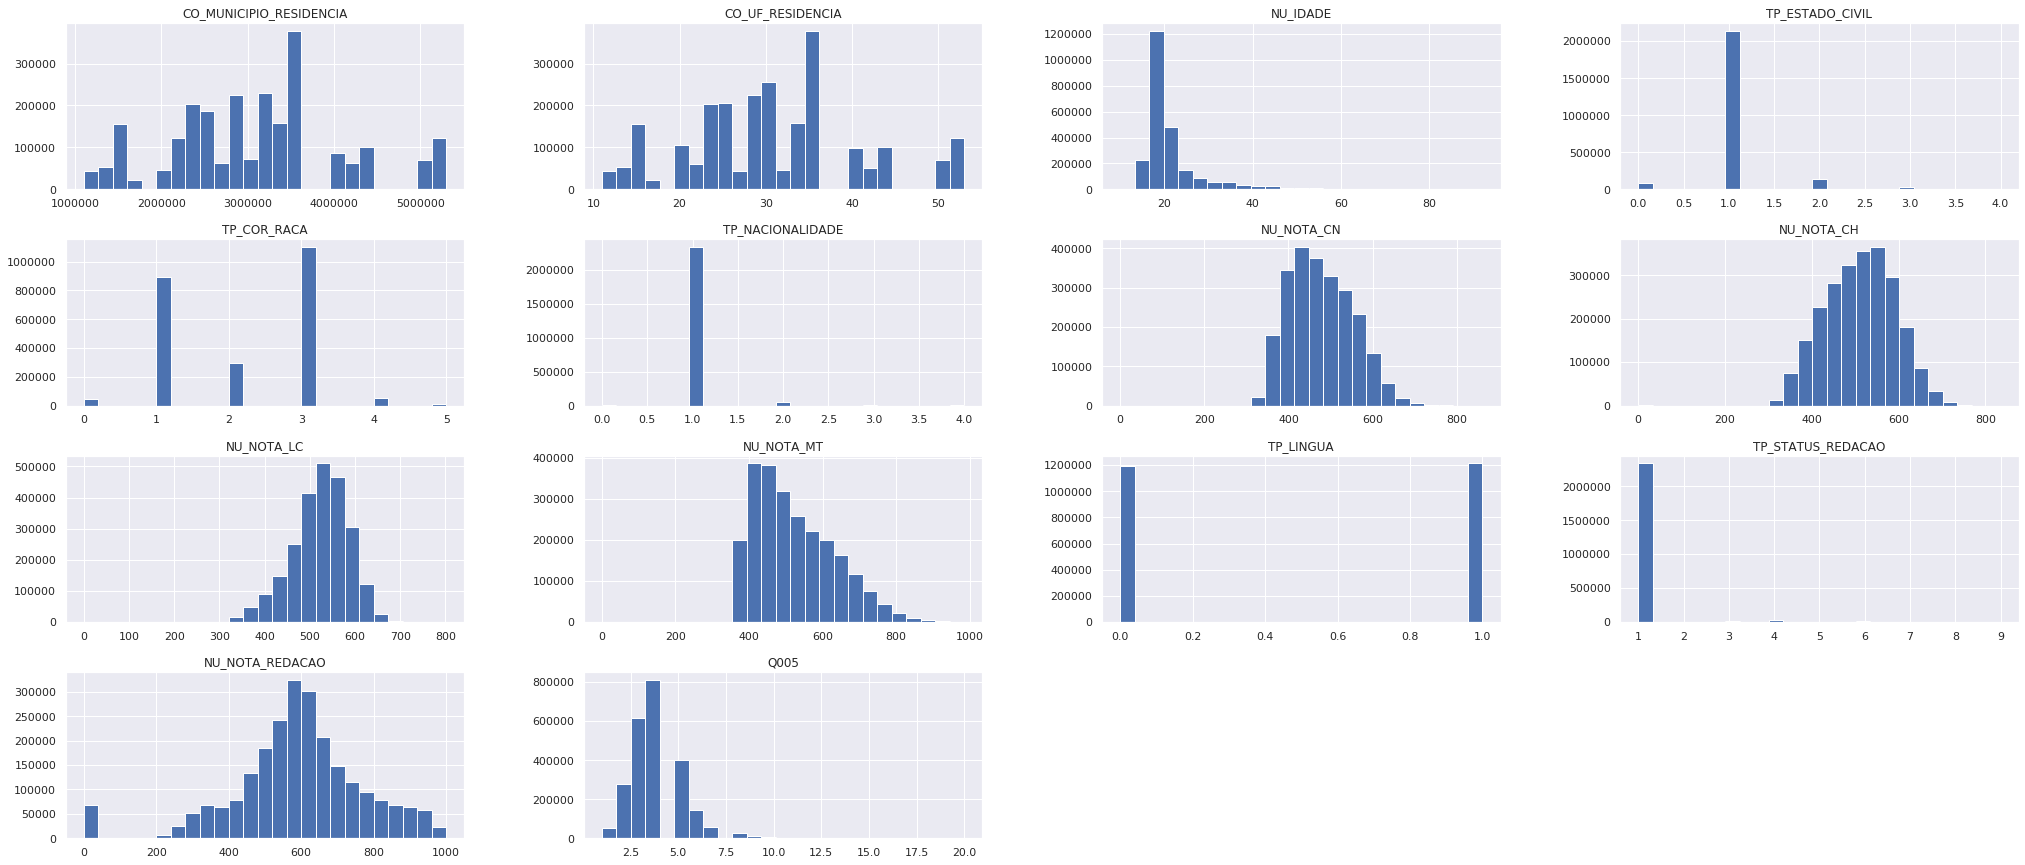

In [32]:
num_attributes.hist(bins=25);

### 1.7.2 Categorical Attributes

In [33]:
cat_attributes.dtypes

NU_INSCRICAO               object
NO_MUNICIPIO_RESIDENCIA    object
SG_UF_RESIDENCIA           object
TP_SEXO                    object
Q001                       object
Q002                       object
Q003                       object
Q004                       object
Q006                       object
Q007                       object
Q008                       object
Q009                       object
Q010                       object
Q011                       object
Q012                       object
Q013                       object
Q014                       object
Q015                       object
Q016                       object
Q017                       object
Q018                       object
Q019                       object
Q020                       object
Q021                       object
Q022                       object
Q023                       object
Q024                       object
Q025                       object
dtype: object

In [36]:
# Checking the unique values of each category
cat_attributes.apply(lambda x: x.unique())

NU_INSCRICAO               [d7e73c5f-2db8-4089-9bee-d3a0e045f87f, 668bf6e...
NO_MUNICIPIO_RESIDENCIA    [Ariquemes, Belo Horizonte, Manhuaçu, Guarabir...
SG_UF_RESIDENCIA           [RO, MG, PB, CE, PI, MA, RN, BA, AL, SP, SC, M...
TP_SEXO                                                               [F, M]
Q001                                                [B, E, C, G, D, F, H, A]
Q002                                                [A, C, B, E, D, F, H, G]
Q003                                                      [A, D, C, B, E, F]
Q004                                                      [A, B, D, F, C, E]
Q006                       [E, F, B, L, G, J, C, D, H, Q, M, A, P, O, N, ...
Q007                                                            [A, D, B, C]
Q008                                                         [B, E, C, D, A]
Q009                                                         [C, D, E, B, A]
Q010                                                         [C, A, B, D, E]

# 2.0. Hypotesis

In [8]:
df2 = df1.copy()

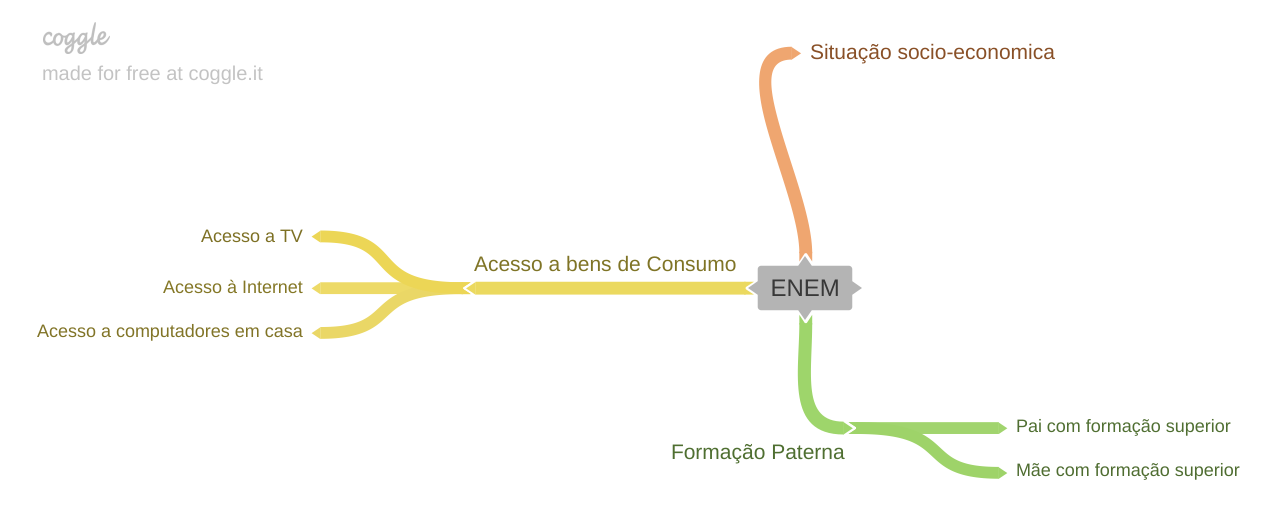

In [40]:
Image('ENEM.png')

### H1. A condição socio-economica pouco interfere no resultados das notas!
## **Falso**: Quanto melhor a condição financeira familiar do estudante maiores serão suas notas!

In [41]:
aux1 = df2[['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q006']].groupby('Q006').mean()
aux1

,NU_NOTA_REDACAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
Q006,,,,,
A,501.94829,440.30224,468.16116,485.93577,468.32153
B,523.26791,445.33722,475.25963,494.00988,475.93106
C,552.09058,461.93511,494.95846,511.95563,496.62070
D,576.30863,477.85352,511.95851,525.73031,521.92822
E,590.26575,483.48169,518.34115,530.82511,529.64909
F,612.05862,497.19214,531.00732,540.24772,552.51033
G,627.34218,503.21513,537.27423,544.96136,561.05974
H,650.95231,517.85823,549.97540,553.94742,583.09254
I,664.69249,524.25680,556.09794,558.23602,594.05366


* A	Nenhuma renda.

* B	Até R$ 998,00.

* C	De R$ 998,01 até R$ 1.497,00.

* D	De R$ 1.497,01 até R$ 1.996,00.

* E	De R$ 1.996,01 até R$ 2.495,00.

* F	De R$ 2.495,01 até R$ 2.994,00.

* G	De R$ 2.994,01 até R$ 3.992,00.

* H	De R$ 3.992,01 até R$ 4.990,00.

* I	De R$ 4.990,01 até R$ 5.988,00.

* J	De R$ 5.988,01 até R$ 6.986,00.

* K	De R$ 6.986,01 até R$ 7.984,00.

* L	De R$ 7.984,01 até R$ 8.982,00.

* M	De R$ 8.982,01 até R$ 9.980,00.

* N	De R$ 9.980,01 até R$ 11.976,00.

* O	De R$ 11.976,01 até R$ 14.970,00.

* P	De R$ 14.970,01 até R$ 19.960,00.

* Q	Mais de R$ 19.960,00.

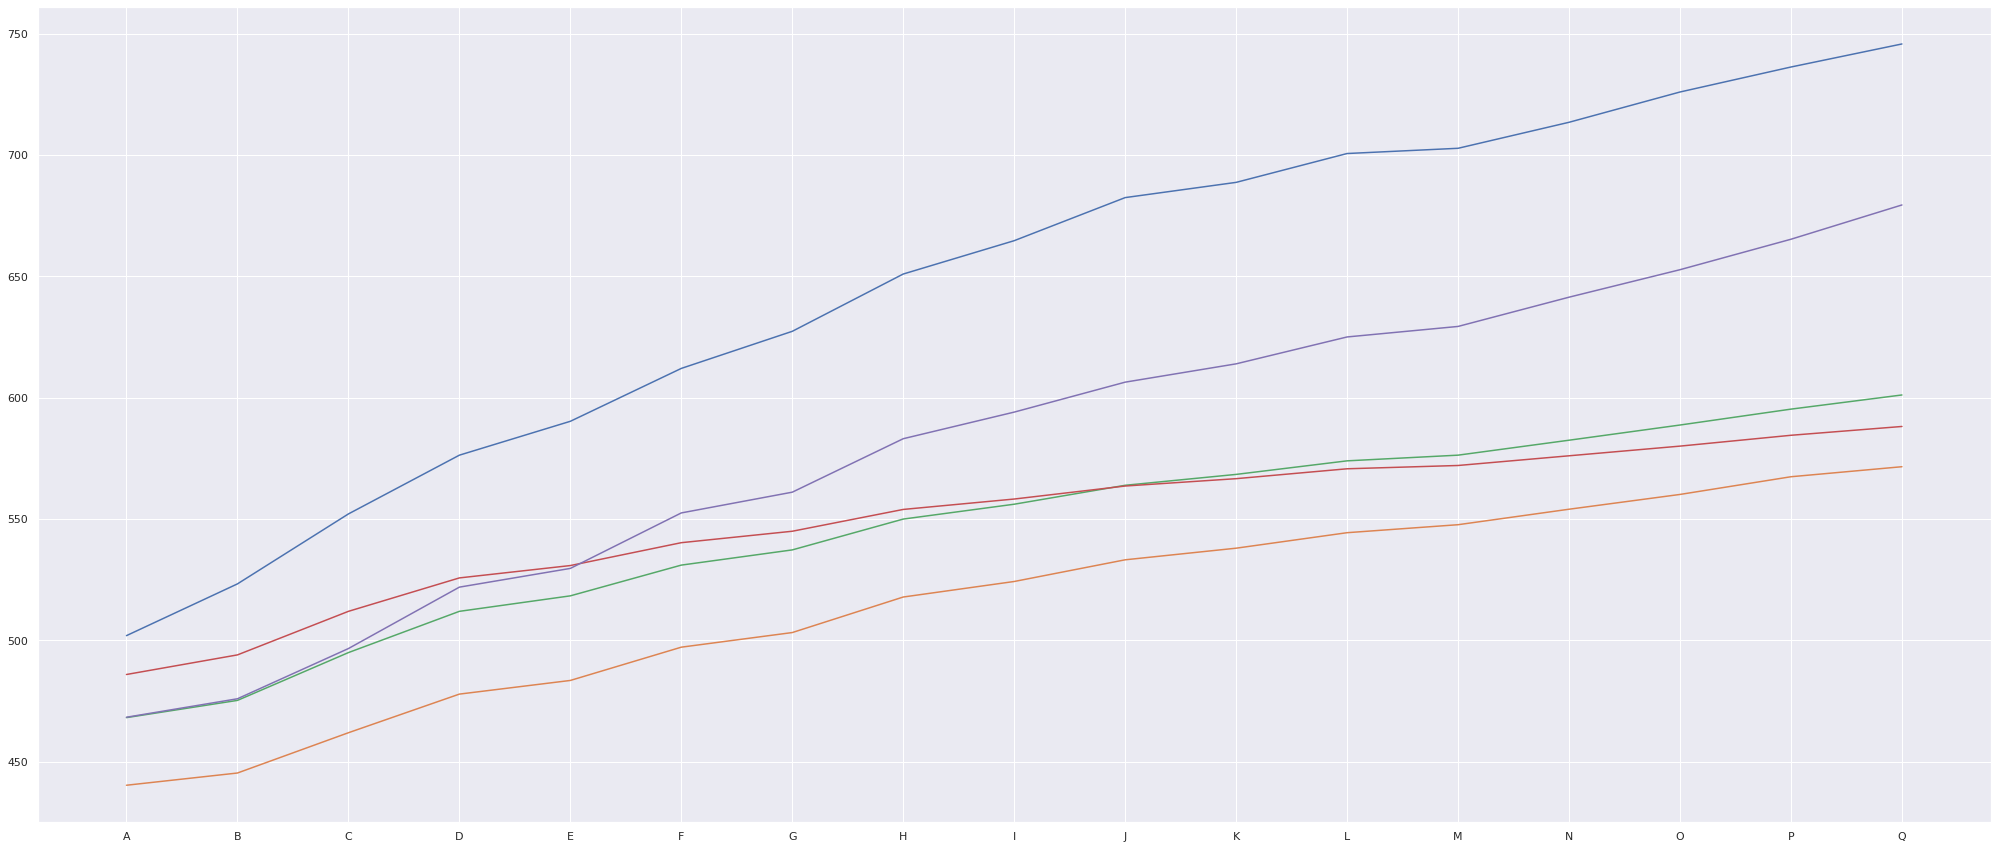

In [16]:
a = df2[['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q006']].groupby('Q006').mean()
plt.plot(a);

### H2. Alunos com acesso a TV em casa obtem melhores resultados?
## **Verdadeiro!**

In [17]:
aux2 = df2[['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q019']].groupby('Q019').mean()
aux2

,NU_NOTA_REDACAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
Q019,,,,,
A,542.73953,461.78969,492.73894,506.74913,497.28139
B,558.84949,465.91893,497.66249,512.79437,504.34885
C,619.32269,500.14921,533.65628,541.80630,557.46838
D,658.16112,521.37825,553.34756,556.47273,592.34525
E,690.74429,539.47419,569.17217,567.91909,624.38834


* A	Não.

* B	Sim, uma.

* C	Sim, duas.

* D	Sim, três.

* E	Sim, quatro ou mais.

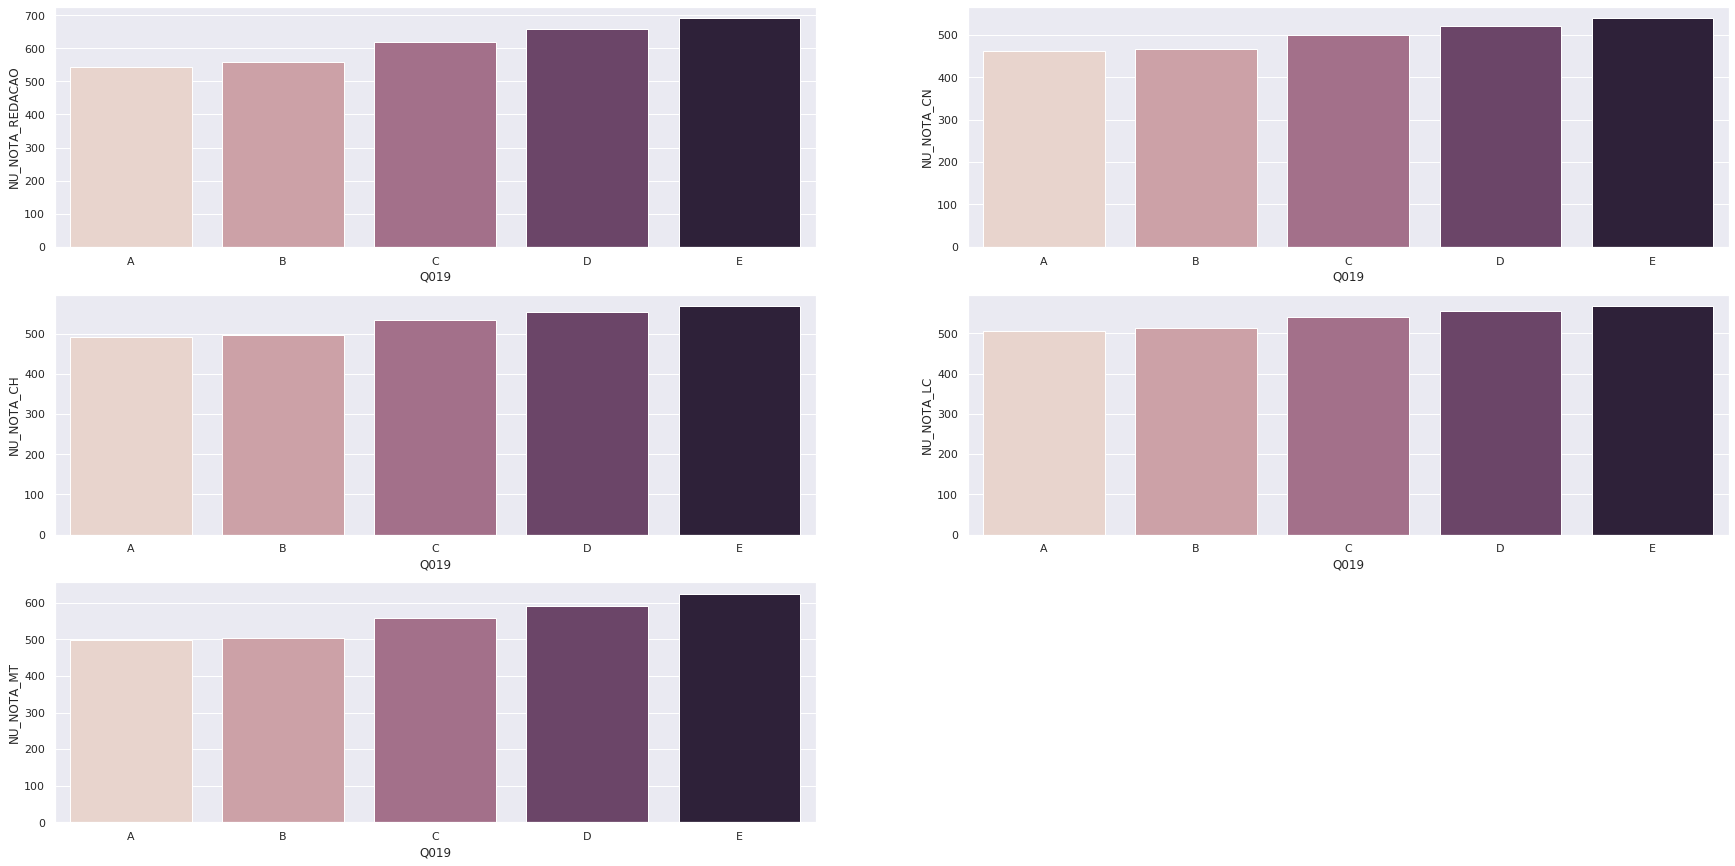

In [68]:
#plt.plot(aux2);
plt.subplot(3, 2, 1)
# Checking product assortment size and sales by each store type. Let's look at which variables make sense to group and return this value
# showing the sum of sales per store categorized by display type (number of products)
aux1 = df2[['NU_NOTA_REDACAO', 'Q019']].groupby('Q019').mean().reset_index()
sns.barplot(x='Q019', y='NU_NOTA_REDACAO', data=aux1, palette="ch:.05");

plt.subplot(3, 2, 2)
# O aux1 já responde essas questão. Daqui em diante vou validar se "extra", "basic" e "extend" 
#faz jús ao tamanho da loja e não apenas um breve comportamento dos clientes.
aux2 = df2[['NU_NOTA_CN', 'Q019']].groupby('Q019').mean().reset_index()
sns.barplot(x='Q019', y='NU_NOTA_CN', data=aux2, palette="ch:.05");

plt.subplot(3, 2, 3)
aux3 = df2[['NU_NOTA_CH', 'Q019']].groupby('Q019').mean().reset_index()
sns.barplot(x='Q019', y='NU_NOTA_CH', data=aux3, palette="ch:.05");

plt.subplot(3, 2, 4)
aux4 = df2[['NU_NOTA_LC', 'Q019']].groupby('Q019').mean().reset_index()
sns.barplot(x='Q019', y='NU_NOTA_LC', data=aux4, palette="ch:.05");

plt.subplot(3, 2, 5)
aux5 = df2[['NU_NOTA_MT', 'Q019']].groupby('Q019').mean().reset_index()
sns.barplot(x='Q019', y='NU_NOTA_MT', data=aux5, palette="ch:.05");

### H3. Alunos com acesso a internet em casa obtem melhores resultados?
## **Verdadeiro!**
* B = sim à acesso a internet
* A = Não á acesso a internet

In [39]:
# Notas relacionadas ao acesso ou não a internet em casa
b = df2[['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q025']].groupby('Q025').mean()
b

,NU_NOTA_REDACAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
Q025,,,,,
A,515.44872,445.43019,474.71460,492.26096,474.71820
B,596.94919,486.57529,519.29975,530.47258,536.15826


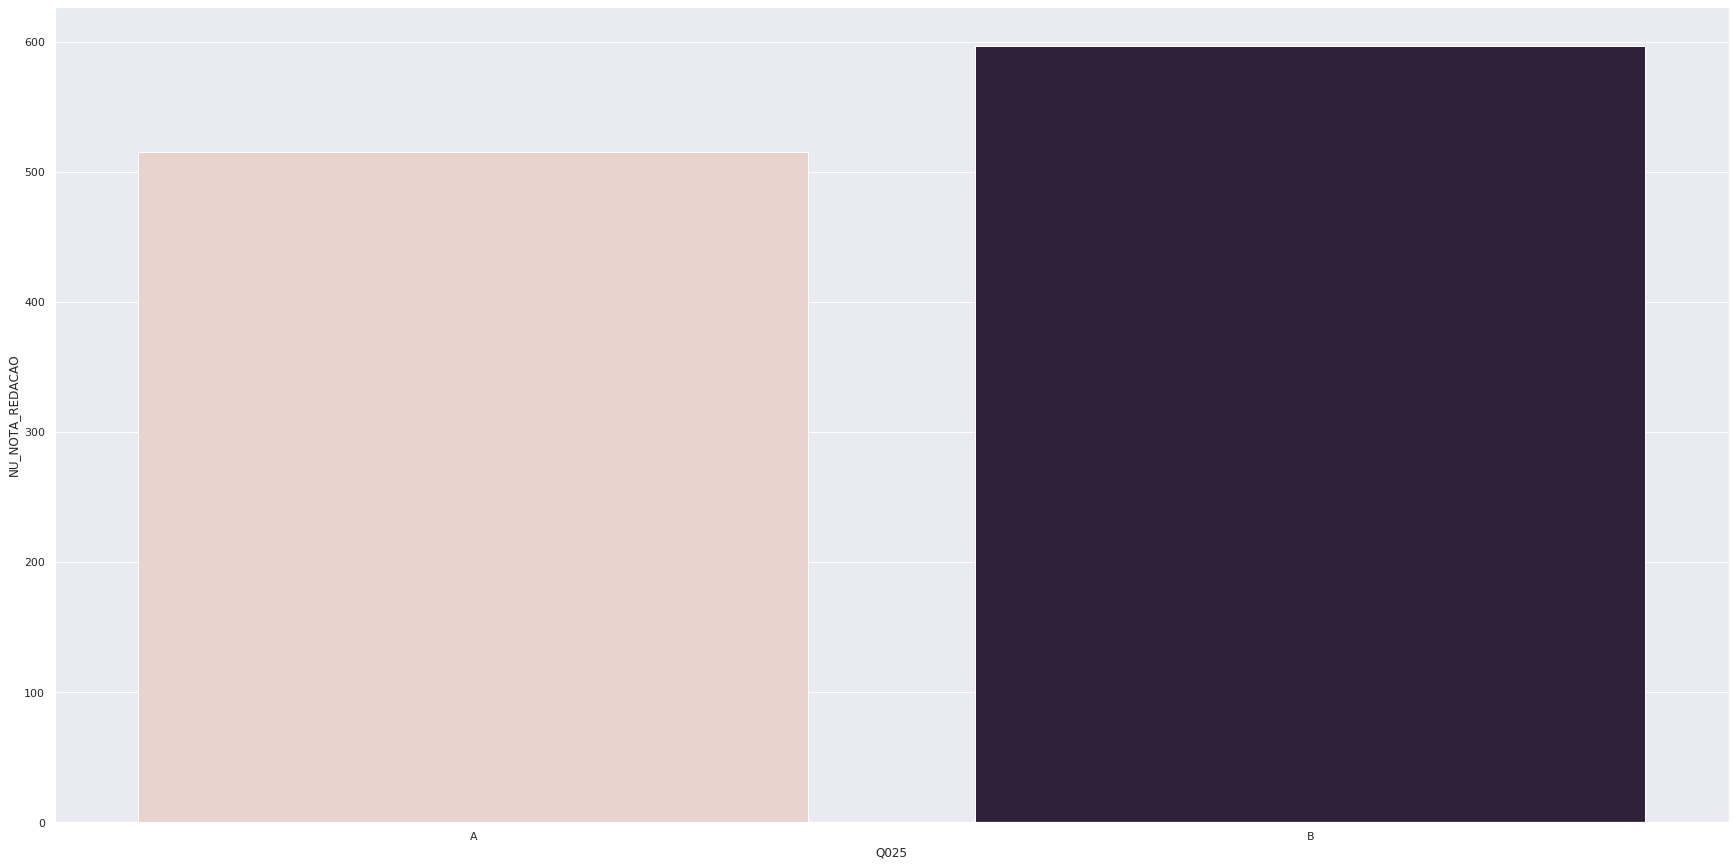

In [73]:
#plt.subplot(3, 2, 1)
# Checking product assortment size and sales by each store type. Let's look at which variables make sense to group and return this value
# showing the sum of sales per store categorized by display type (number of products)
aux1 = df2[['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q025']].groupby('Q025').mean().reset_index()
sns.barplot(x='Q025', y='NU_NOTA_REDACAO', data=aux1, palette="ch:.05");


### H4. Alunos com acesso a computadores em casa obtem melhores resultados?
## **Verdadeiro!**

* A Não.

* B Sim, um.

* C Sim, dois.

* D Sim, três.

* E Sim, quatro ou mais.

In [34]:
# Notas relacionadas ao acesso ou não a internet em casa
aux3 = df2[['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q024']].groupby('Q024').mean()
aux3

,NU_NOTA_REDACAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
Q024,,,,,
A,529.77876,450.04375,480.65617,499.30938,483.37254
B,602.01657,489.16719,522.65246,533.07010,538.00111
C,669.82030,531.01457,563.27841,563.01622,601.88578
D,701.04299,551.37437,581.80692,576.07783,635.90393
E,715.85287,564.01981,592.94121,583.78828,661.02960


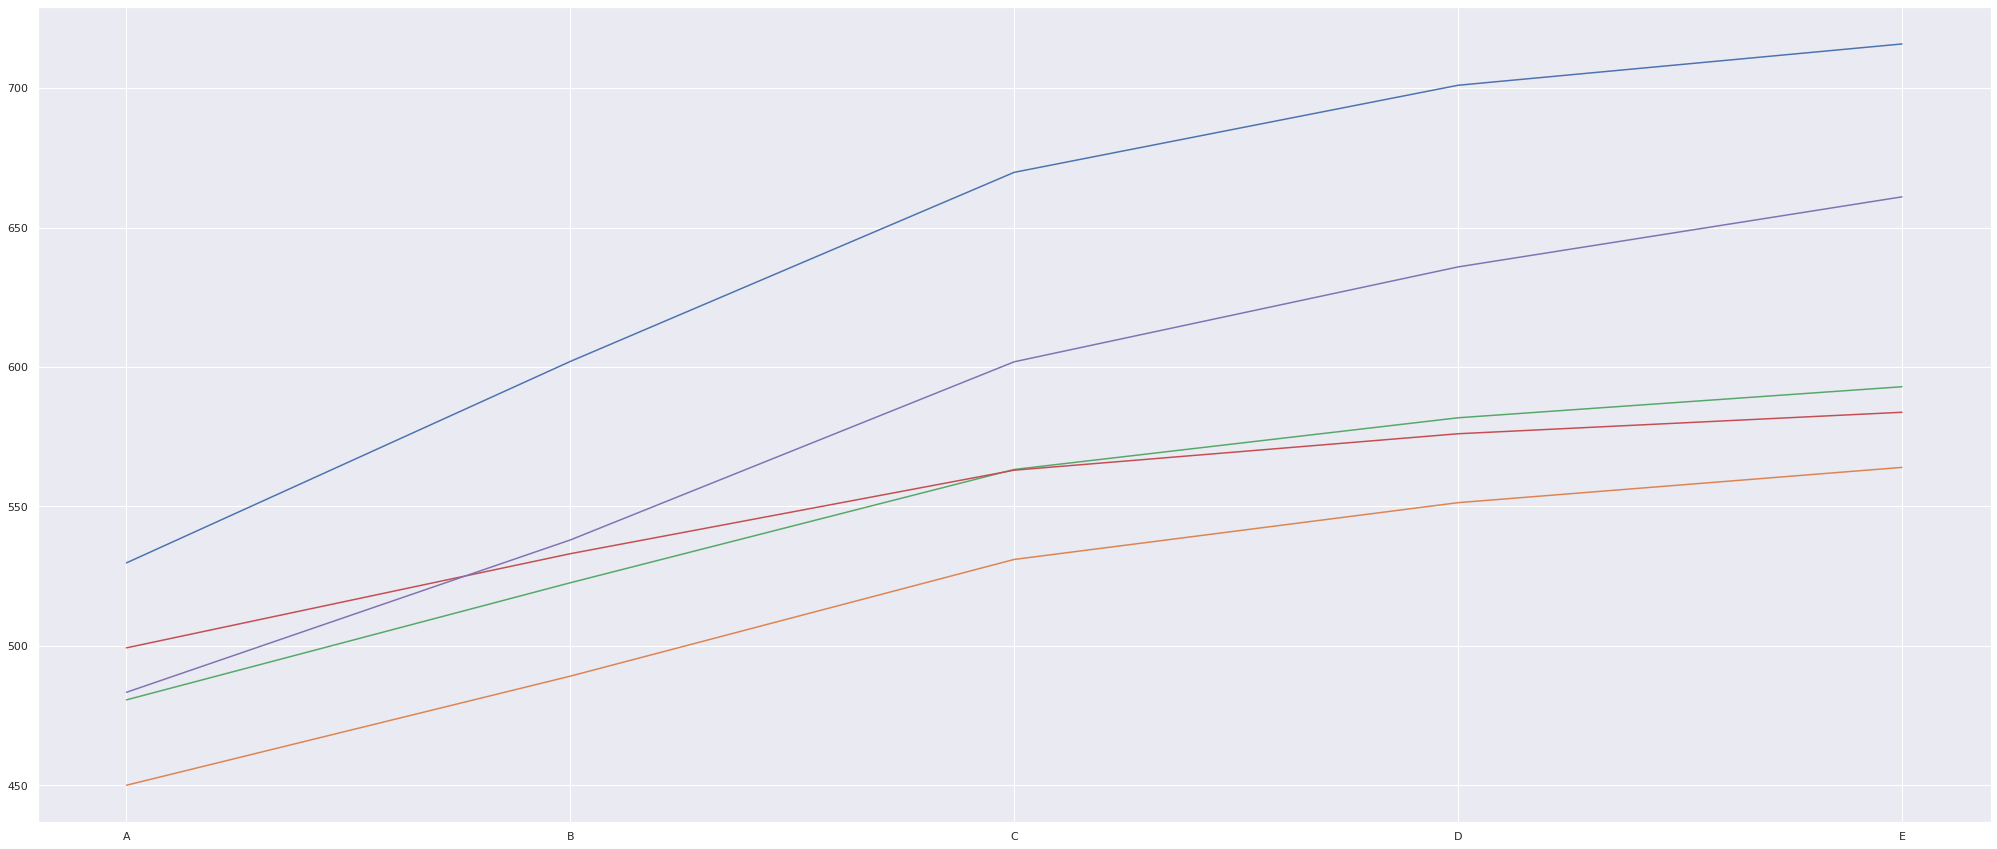

In [36]:
plt.plot(aux3);

### H5. Alunos cujo os pais tem formação superior, tem as melhores notas!
## **Verdadeiro!**

* A	Nunca estudou.

* B	Não completou a 4ª série/5º ano do Ensino Fundamental.

* C	Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.

* D	Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.

* E	Completou o Ensino Médio, mas não completou a Faculdade.

* F	Completou a Faculdade, mas não completou a Pós-graduação.

* G	Completou a Pós-graduação.

* H	Não sei.


In [37]:
# Notas relacionadas ao acesso ou não a internet em casa
aux4 = df2[['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q001']].groupby('Q001').mean()
aux4

,NU_NOTA_REDACAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
Q001,,,,,
A,495.76855,442.38214,471.99219,486.74540,466.23319
B,532.62101,454.43000,486.17798,502.14248,486.54550
C,558.09236,465.19686,497.68100,513.10752,505.23820
D,574.69698,471.90524,504.55876,519.72348,515.63902
E,604.85021,488.25642,521.22789,533.26858,538.98070
F,673.57643,528.81595,559.46286,560.84113,600.06957
G,700.19290,543.74764,572.61982,569.34630,624.23914
H,537.00840,459.96594,492.40487,509.21908,495.55026


### H6. Alunos cujo as mães tem formação superior, tem as melhores notas!
## **Verdadeiro!**

* A	Nunca estudou.

* B	Não completou a 4ª série/5º ano do Ensino Fundamental.

* C	Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.

* D	Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.

* E	Completou o Ensino Médio, mas não completou a Faculdade.

* F	Completou a Faculdade, mas não completou a Pós-graduação.

* G	Completou a Pós-graduação.

* H	Não sei.


In [38]:
# Notas relacionadas ao acesso ou não a internet em casa
aux5 = df2[['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q002']].groupby('Q002').mean()
aux5

,NU_NOTA_REDACAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
Q002,,,,,
A,482.22510,440.87367,470.83069,484.04215,460.08365
B,522.30264,451.52821,483.69718,499.10212,480.26270
C,543.75971,459.67351,492.33407,508.19737,496.08270
D,559.02756,464.78703,497.60777,514.14613,504.91339
E,590.96451,480.82045,513.75431,527.58138,528.24786
F,655.50363,517.36626,547.90661,552.33342,583.39881
G,676.16517,527.05217,556.79970,558.13227,598.75662
H,504.78207,450.72796,479.11794,494.98531,484.34807


In [96]:
df3.columns

Index(['NU_INSCRICAO', 'CO_MUNICIPIO_RESIDENCIA', 'NO_MUNICIPIO_RESIDENCIA',
       'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO',
       'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'NU_NOTA_CN',
       'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'TP_LINGUA',
       'TP_STATUS_REDACAO', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q003', 'Q004',
       'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013',
       'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022',
       'Q023', 'Q024', 'Q025'],
      dtype='object')

# 30. EDA

In [41]:
df3 = df2.copy()

### 3.1. Univariate Analysis

#### 3.1.0. Numerical Variable

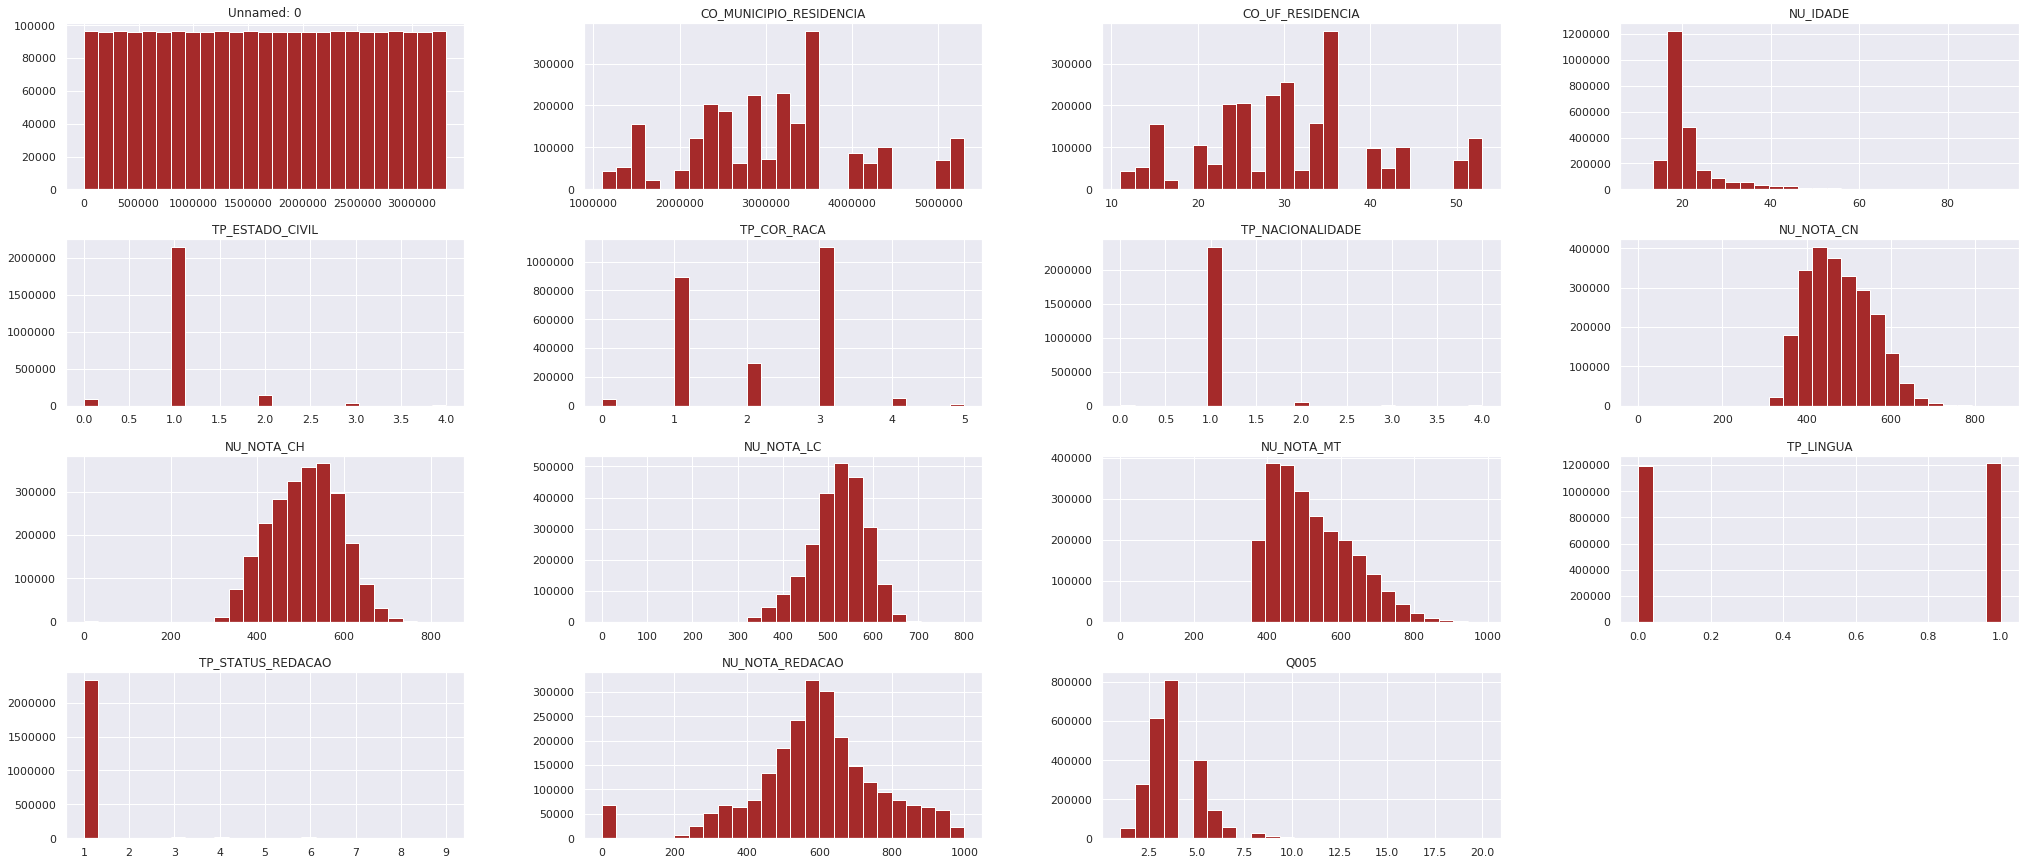

In [46]:
num_attributes.hist(bins=25, color='brown');
plt.rcParams['figure.figsize'] = [30, 15]

#### 3.2.0. Categorical Varible

In [75]:
cat_attributes.head()

,NU_INSCRICAO,NO_MUNICIPIO_RESIDENCIA,SG_UF_RESIDENCIA,TP_SEXO,Q001,Q002,Q003,Q004,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,d7e73c5f-2db8-4089-9bee-d3a0e045f87f,Ariquemes,RO,F,B,A,A,A,E,A,B,C,C,C,B,B,B,B,B,A,A,B,A,A,C,A,B,B
1,668bf6e4-ddf7-4810-b31e-7d325e36de4d,Belo Horizonte,MG,F,B,C,D,B,E,A,B,C,A,A,B,A,B,A,A,A,A,B,A,A,C,A,B,B
2,951e80d6-ac9b-4ff2-8130-fcbc8ac78b16,Manhuaçu,MG,M,E,B,C,D,F,A,B,C,B,A,B,A,B,A,B,A,B,C,B,B,D,A,B,B
3,baf409f9-ddc6-4e82-9a4b-b64b579cd105,Guarabira,PB,M,C,E,B,B,B,A,B,D,A,A,B,B,A,A,B,A,A,B,A,A,E,A,A,B
4,9fd415ac-3421-44ce-810e-599545c3c025,Fortaleza,CE,M,G,E,E,B,L,D,E,E,B,A,B,A,B,A,B,A,A,E,B,B,C,B,B,B


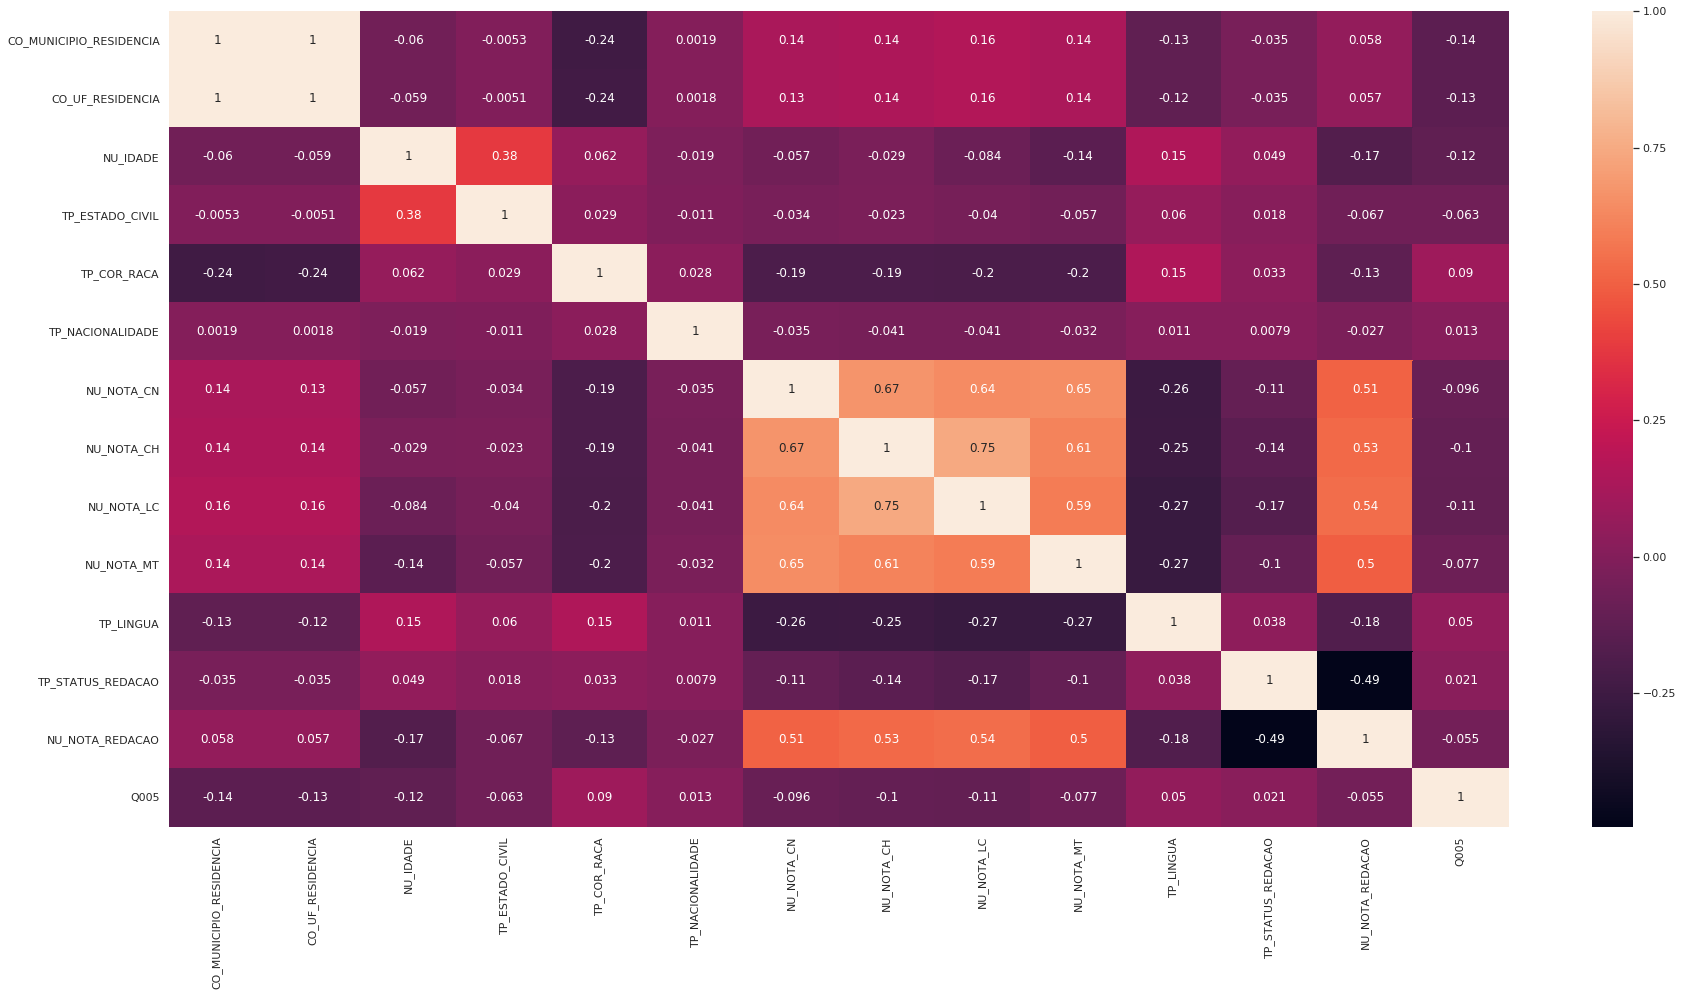

In [77]:

sns.heatmap( df3.corr( method='pearson'), annot=True);

In [81]:
tab = [['Hyposthesis', 'Conclusion', 'Relevance'],
       ['H1', 'Verdadeiro', 'Alto'],
       ['H2', 'Verdadeiro', 'Alto'],
       ['H3', 'Verdadeiro', 'Alto'],
       ['H4', 'Verdadeiro', 'Alto'],
       ['H5', 'Verdadeiro', 'Alto'],
       ['H6', 'Verdadeiro', 'Alto'],
      ]
print( tabulate( tab, headers='firstrow'))

Hyposthesis    Conclusion    Relevance
-------------  ------------  -----------
H1             Falso         Alto
H2             Verdadeiro    Alto
H3             Verdadeiro    Alto
H4             Verdadeiro    Alto
H5             Verdadeiro    Alto
H6             Verdadeiro    Alto
